In [1]:
# --- Manejo de datos ---
import pandas as pd
import numpy as np
import geopandas as gpd

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
# --- Preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# --- Modelado (Clasificación y Clustering) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# --- Evaluación de modelos ---
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- Configuración general ---
pd.set_option('display.max_columns', None)

# --- Suprimir advertencias ---
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import zscore
from scipy.stats import zscore
import folium

In [2]:
df = pd.read_pickle("data/df_EDA.pkl")

In [3]:
df.info(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8316782 entries, 0 to 8316828
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
dtypes: float64(7

In [4]:
df.describe()

,id,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
count,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06,8.316782e+06
mean,7.434818e+06,2.535457e-01,1.723887e-01,1.184081e+03,1.129775e+01,2.316771e+01,3.648317e+01,1.164658e+06,1.885952e+06,2.010827e+03,4.184265e+01,-8.767128e+01
std,3.735356e+06,4.350406e-01,3.777179e-01,7.036538e+02,6.962133e+00,1.340488e+01,2.098951e+01,1.686719e+04,3.226760e+04,6.938866e+00,8.877950e-02,6.112074e-02
min,6.340000e+02,0.000000e+00,0.000000e+00,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.001000e+03,3.661945e+01,-9.168657e+01
25%,4.012970e+06,0.000000e+00,0.000000e+00,6.210000e+02,6.000000e+00,1.100000e+01,2.400000e+01,1.153216e+06,1.859357e+06,2.005000e+03,4.176945e+01,-8.771275e+01
50%,7.434106e+06,0.000000e+00,0.000000e+00,1.034000e+03,1.000000e+01,2.400000e+01,3.000000e+01,1.166183e+06,1.890983e+06,2.010000e+03,4.185642e+01,-8.766562e+01
75%,1.078613e+07,1.000000e+00,0.000000e+00,1.731000e+03,1.700000e+01,3.200000e+01,5.300000e+01,1.176352e+06,1.909100e+06,2.016000e+03,4.190641e+01,-8.762833e+01
max,1.383939e+07,1.000000e+00,1.000000e+00,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951622e+06,2.025000e+03,4.202291e+01,-8.752453e+01


# Group by
## Sistema de Clasificación IUCR

El Chicago Police Department utiliza el sistema de codificación Illinois Uniform Crime Reporting (IUCR), el cual se alinea con las directrices del FBI para el reporte uniforme de crímenes. Este sistema categoriza las infracciones en dos grandes grupos: delitos índice (Index crimes) y delitos no índice (Non-Index crimes). 

 📌 *Este análisis fue recomendado y desarrollado en colaboración con Baudilio Marquez, quien ha contribuido significativamente a la comprensión del sistema IUCR en el contexto de nuestro proyecto conjunto.*


a. Delitos Índice (Index Crimes)

In [5]:
df['primary_type'].value_counts()

primary_type
THEFT                                1763501
BATTERY                              1515233
CRIMINAL DAMAGE                       945912
NARCOTICS                             760775
ASSAULT                               554437
OTHER OFFENSE                         518206
BURGLARY                              440837
MOTOR VEHICLE THEFT                   423066
DECEPTIVE PRACTICE                    381009
ROBBERY                               311846
CRIMINAL TRESPASS                     224346
WEAPONS VIOLATION                     122357
PROSTITUTION                           70317
OFFENSE INVOLVING CHILDREN             59683
PUBLIC PEACE VIOLATION                 54266
SEX OFFENSE                            33598
CRIM SEXUAL ASSAULT                    27323
INTERFERENCE WITH PUBLIC OFFICER       19820
LIQUOR LAW VIOLATION                   15305
GAMBLING                               14657
ARSON                                  14257
HOMICIDE                               137

In [6]:
#creo una lista con los delitos mas graves y mas frecuentes para filtrar el dataframe
index_crimes = {
   "HOMICIDE": "Violento",
    "CRIMINAL SEXUAL ASSAULT": "Violento",
    "ROBBERY": "Violento",
    "AGGRAVATED ASSAULT": "Violento",
    "AGGRAVATED BATTERY": "Violento",
    "BURGLARY": "Contra la propiedad",
    "THEFT": "Contra la propiedad",
    "MOTOR VEHICLE THEFT": "Contra la propiedad",
    "ARSON": "Incendio"
}
df_index=df[df['primary_type'].isin(index_crimes)].copy()

In [7]:
df_index.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2977917 entries, 4 to 8316827
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
dtypes: float64(7

In [8]:
df_index.head(2)

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only
4,13204489,JG416325,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),0,0,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,41.871835,-87.626151,2023-09-06,11:00:00,2023-11-04,15:40:18
5,11695116,JC272771,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,0,0,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,41.856547,-87.695605,2019-05-21,08:20:00,2024-01-19,15:40:50


In [9]:
df_index.describe()

,id,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
count,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06,2.977917e+06
mean,7.531789e+06,9.644762e-02,2.785000e-02,1.225664e+03,1.167372e+01,2.409655e+01,3.472932e+01,1.165110e+06,1.888865e+06,2.011050e+03,4.185063e+01,-8.766953e+01
std,3.759945e+06,2.952042e-01,1.645430e-01,7.197445e+02,7.130026e+00,1.408930e+01,2.125376e+01,1.672714e+04,3.262002e+04,6.991082e+00,8.974492e-02,6.052591e-02
min,6.340000e+02,0.000000e+00,0.000000e+00,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.001000e+03,3.661945e+01,-9.168657e+01
25%,4.122996e+06,0.000000e+00,0.000000e+00,6.230000e+02,6.000000e+00,1.100000e+01,2.200000e+01,1.154765e+06,1.861276e+06,2.005000e+03,4.177497e+01,-8.770723e+01
50%,7.647837e+06,0.000000e+00,0.000000e+00,1.132000e+03,1.100000e+01,2.600000e+01,2.800000e+01,1.166601e+06,1.896142e+06,2.010000e+03,4.187082e+01,-8.766404e+01
75%,1.087291e+07,0.000000e+00,0.000000e+00,1.824000e+03,1.800000e+01,3.500000e+01,5.000000e+01,1.176338e+06,1.912459e+06,2.017000e+03,4.191559e+01,-8.762834e+01
max,1.383938e+07,1.000000e+00,1.000000e+00,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951622e+06,2.025000e+03,4.202291e+01,-8.752453e+01


Porcentaje de arrestos para cada tipo de delito INDEX_CRIMES


In [10]:
df_index.groupby("primary_type")["arrest"].mean().sort_values(ascending=False)

primary_type
HOMICIDE                   0.478672
ARSON                      0.122887
THEFT                      0.108694
ROBBERY                    0.092453
MOTOR VEHICLE THEFT        0.076485
CRIMINAL SEXUAL ASSAULT    0.073340
BURGLARY                   0.057214
Name: arrest, dtype: float64

In [11]:
#he generado una nueva columna 'arrest_mean' que contiene el pormedio de arrestos por los delitos mas graves
df_index['arrest_mean']=df_index['arrest'].mean()

In [12]:
arrest_rate = df_index['arrest'].mean()
print(arrest_rate)

0.09644761757967062


## Análisis espacial

Lugar mas frecuente por tipo de delito

In [13]:
#con esta instruccion quiero hacer un analiss espacial de los delitos mas graves y frecuentes
df_index.groupby("primary_type")["location_description"].agg(lambda x: x.mode().iloc[0])

primary_type
ARSON                      VEHICLE NON-COMMERCIAL
BURGLARY                                RESIDENCE
CRIMINAL SEXUAL ASSAULT                 APARTMENT
HOMICIDE                                   STREET
MOTOR VEHICLE THEFT                        STREET
ROBBERY                                    STREET
THEFT                                      STREET
Name: location_description, dtype: object

Moda de location_description por tipo de delito

In [14]:
moda_localizacion = df_index.groupby("primary_type")["location_description"]\
    .agg(lambda x: x.mode().iloc[0]).reset_index(name="location_mode")

Calculo de coordenadas medias para cada tipo de delito y lugar
con esto quiero ver el lugar promedio de cada uno de los eventos 

In [15]:
coordenadas = df_index.groupby(["primary_type", "location_description"])[["latitude", "longitude"]]\
    .mean().reset_index()

# Unir para quedarnos solo con la moda y su ubicación media
df_mapa = moda_localizacion.merge(coordenadas,
                                   left_on=["primary_type", "location_mode"],
                                   right_on=["primary_type", "location_description"])

In [16]:
# Centro del mapa (Chicago)
map_center = [41.88, -87.63]
m = folium.Map(location=map_center, zoom_start=11)

# Dibujar cada moda de localización como un punto rojo
for _, row in df_mapa.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=f"{row['primary_type']}: {row['location_mode']}"
    ).add_to(m)

m

In [17]:
df_index[['latitude','longitude']].describe()

,latitude,longitude
count,2.977917e+06,2.977917e+06
mean,4.185063e+01,-8.766953e+01
std,8.974492e-02,6.052591e-02
min,3.661945e+01,-9.168657e+01
25%,4.177497e+01,-8.770723e+01
50%,4.187082e+01,-8.766404e+01
75%,4.191559e+01,-8.762834e+01
max,4.202291e+01,-8.752453e+01


In [18]:
#El valor mínimo de latitud ( min = 36.61) y longitud ( min = -91.68)
#  están muy lejos de Chicago (probablemente errores de geocodificación o datos mal cargados
# Filtro solo los datos dentro del rango esperado para Chicago
df_chicago = df_index[
    (df_index['latitude'] >= 41.6) & (df_index['latitude'] <= 42.1) &
    (df_index['longitude'] >= -88) & (df_index['longitude'] <= -87.3)
]

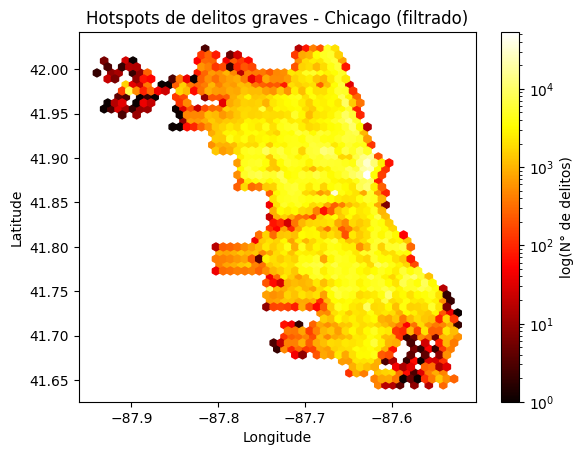

In [19]:
plt.hexbin(df_chicago['longitude'], df_chicago['latitude'], gridsize=50, cmap='hot', bins='log')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hotspots de delitos graves - Chicago (filtrado)')
plt.colorbar(label='log(N° de delitos)')
plt.show()

Lugares donde ocurren mas delitos

In [20]:
#con est instruccion filtro los 10 lugares mas comunes donde ocurren los delitros graves
top_locations = df_index["location_description"].value_counts().head(10).index
#ahora quiero filtrar el dataframe para quedarme solo con los delitos que ocurren en sos lugares
df_top_loc = df_index[df_index["location_description"].isin(top_locations)]

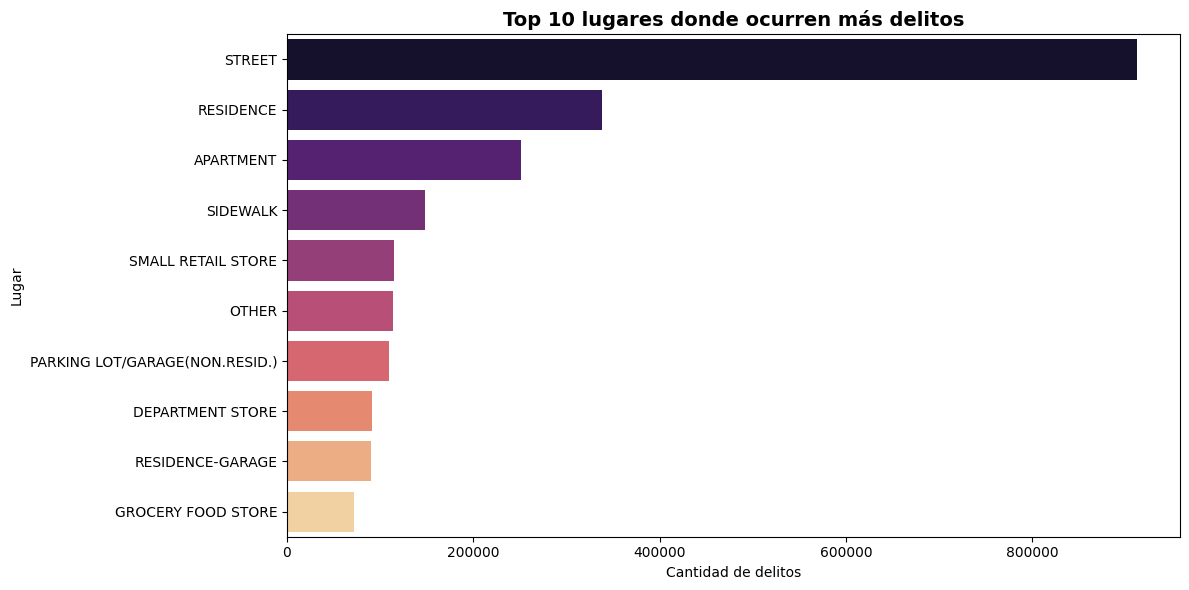

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_top_loc,
    y="location_description",
    order=top_locations,
    palette="magma"
)

plt.title("Top 10 lugares donde ocurren más delitos", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de delitos")
plt.ylabel("Lugar")
plt.tight_layout()
plt.show()


Resumen estadístico general de arrestos y ubicaciones

In [22]:
df_index[["arrest", "latitude", "longitude"]].describe()

,arrest,latitude,longitude
count,2.977917e+06,2.977917e+06,2.977917e+06
mean,9.644762e-02,4.185063e+01,-8.766953e+01
std,2.952042e-01,8.974492e-02,6.052591e-02
min,0.000000e+00,3.661945e+01,-9.168657e+01
25%,0.000000e+00,4.177497e+01,-8.770723e+01
50%,0.000000e+00,4.187082e+01,-8.766404e+01
75%,0.000000e+00,4.191559e+01,-8.762834e+01
max,1.000000e+00,4.202291e+01,-8.752453e+01


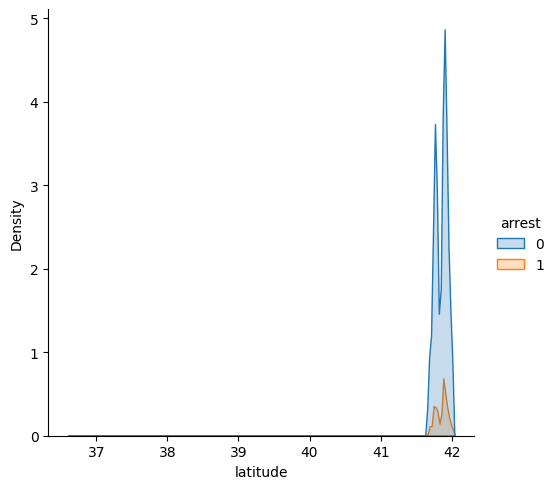

In [23]:
#con esta instruccion queiro obervar la distribucion de delitos segun la laititus y los arrestos
sns.displot(df_index, x="latitude", hue="arrest", kind="kde", fill=True)

Calles con mas delitos

In [24]:
df_index['block'].value_counts().head(10)

block
001XX N STATE ST        11945
076XX S CICERO AVE       8551
0000X N STATE ST         8507
008XX N MICHIGAN AVE     7406
100XX W OHARE ST         6809
0000X S STATE ST         3372
006XX N MICHIGAN AVE     3295
001XX W 87TH ST          3280
046XX W NORTH AVE        3129
026XX N ELSTON AVE       3018
Name: count, dtype: int64

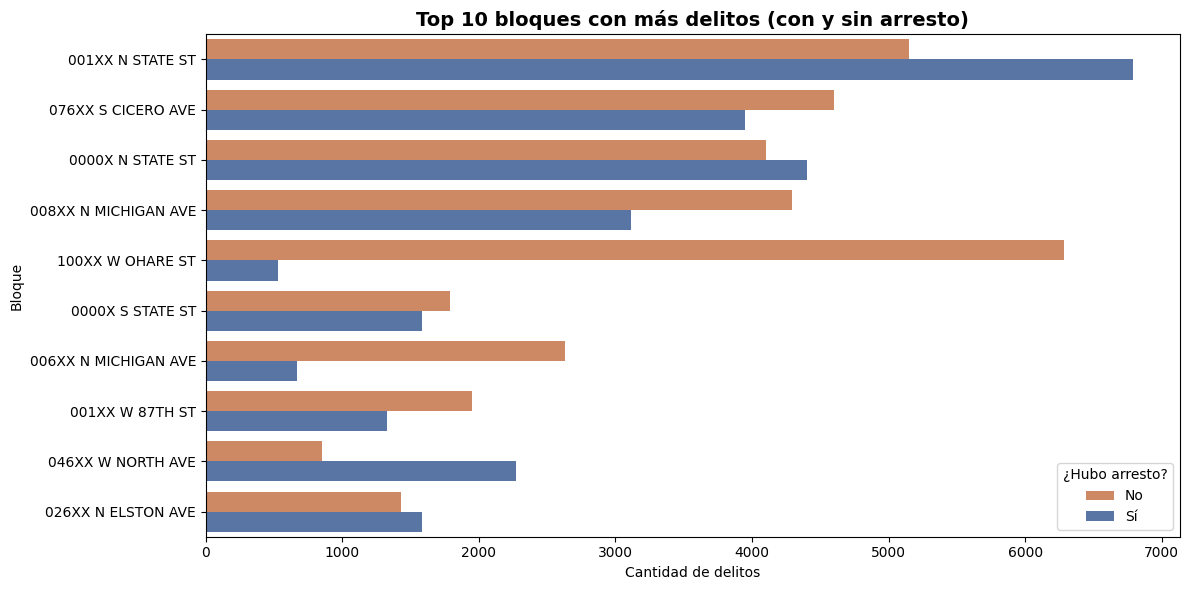

In [25]:
top_blocks = df_index["block"].value_counts().head(10).index
df_top = df_index[df_index["block"].isin(top_blocks)]

custom_palette = {True: "#4C72B0", False: "#DD8452"} # Azul y rojo fuertes

# Gráfico
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_top,
    y="block",
    hue="arrest",
    order=top_blocks,
    palette=custom_palette
)

plt.title("Top 10 bloques con más delitos (con y sin arresto)", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de delitos")
plt.ylabel("Bloque")
plt.legend(title="¿Hubo arresto?", labels=["No", "Sí"])
plt.tight_layout()
plt.show()

Conteo de delito por tipo principal

In [26]:

df_index.groupby('primary_type')[['block']].count()


,block
primary_type,
ARSON,14257
BURGLARY,440837
CRIMINAL SEXUAL ASSAULT,10649
HOMICIDE,13761
MOTOR VEHICLE THEFT,423066
ROBBERY,311846
THEFT,1763501


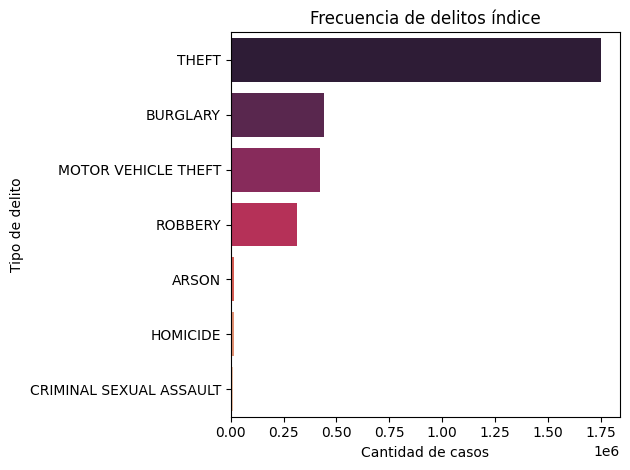

In [27]:
# Datos agrupados
counts = {
    'ARSON': 14256,
    'BURGLARY': 440772,
    'CRIMINAL SEXUAL ASSAULT': 10631,
    'HOMICIDE': 13724,
    'MOTOR VEHICLE THEFT': 421767,
    'ROBBERY': 311783,
    'THEFT': 1752953
}

df_counts = pd.DataFrame(list(counts.items()), columns=["primary_type", "count"])
df_counts = df_counts.sort_values("count", ascending=False)
# Barplot
sns.barplot(data=df_counts, x="count", y="primary_type", palette="rocket")
plt.title("Frecuencia de delitos índice")
plt.xlabel("Cantidad de casos")
plt.ylabel("Tipo de delito")
plt.tight_layout()
plt.show()

In [28]:
df_index.info(3)

<class 'pandas.core.frame.DataFrame'>
Index: 2977917 entries, 4 to 8316827
Data columns (total 24 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
 23  arrest_mean 

## Analisis temporal

1. Delitos por año 

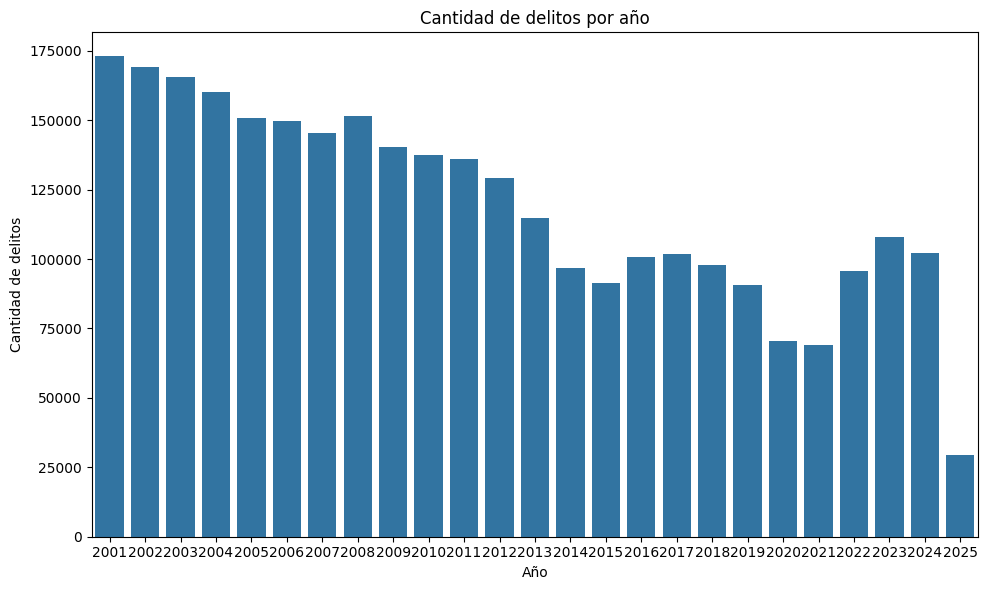

In [29]:
delitosIndex_por_año=df_index['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=delitosIndex_por_año.index, y=delitosIndex_por_año.values)
plt.title("Cantidad de delitos por año")
plt.xlabel("Año")     
plt.ylabel("Cantidad de delitos")
plt.tight_layout()
plt.show()

2. Delitos por mes (tendencia estacional)
Ahora veremos como varian los delitos por mes

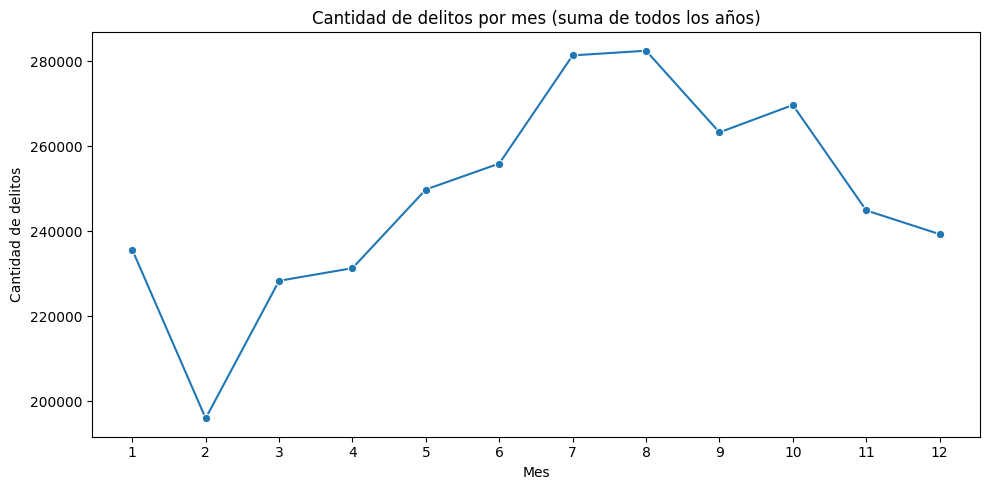

In [30]:
# Asegúrate de que la columna 'date_only' esté en formato datetime
df_index['date_only'] = pd.to_datetime(df_index['date_only'], errors='coerce')

# Extrae el mes
df_index['month'] = df_index['date_only'].dt.month

# Agrupa por mes los datos
delitosIndex_por_mes = df_index['month'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=delitosIndex_por_mes.index, y=delitosIndex_por_mes.values, marker='o')
plt.title('Cantidad de delitos por mes (suma de todos los años)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de delitos')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

3. Delitos por día de la semana


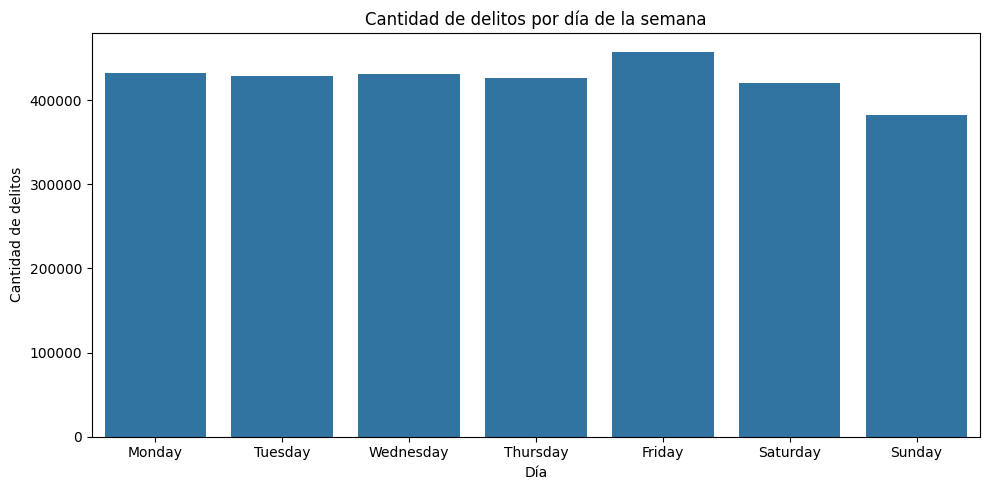

In [31]:
df_index['day_of_week'] = pd.to_datetime(df_index['date_only']).dt.day_name()

# Orden lógico de los días
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

delitos_por_dia = df_index['day_of_week'].value_counts().reindex(dias_orden)

plt.figure(figsize=(10,5))
sns.barplot(x=delitos_por_dia.index, y=delitos_por_dia.values)
plt.title('Cantidad de delitos por día de la semana')
plt.xlabel('Día')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

4.Frecuenacia de delito por hora (extraigo otro formato numerico)

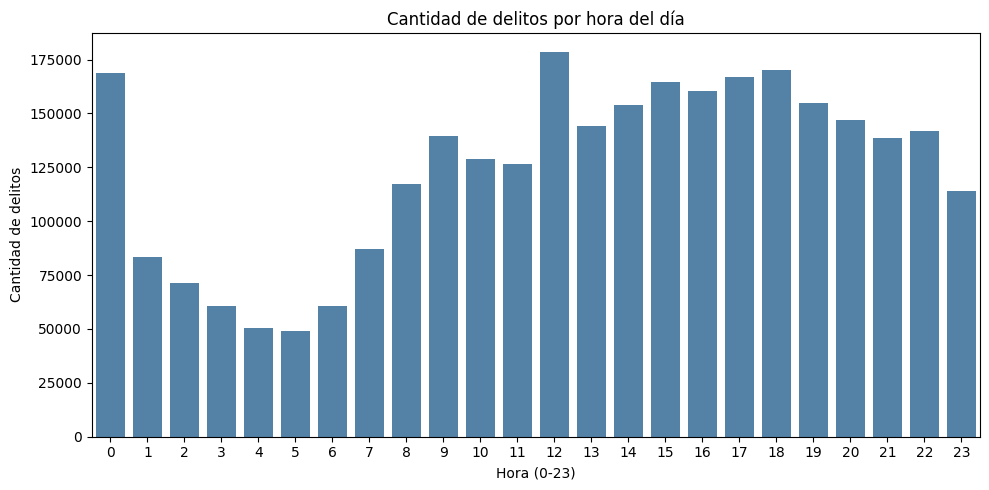

In [32]:
# Extraer la hora de la columna 'time_only' si no existe la columna 'hour'
if 'hour' not in df_index.columns:
	df_index['hour'] = pd.to_datetime(df_index['time_only'], errors='coerce').dt.hour

delitos_por_hora = df_index['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=delitos_por_hora.index, y=delitos_por_hora.values, color='steelblue')
plt.title('Cantidad de delitos por hora del día')
plt.xlabel('Hora (0-23)')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

Detectar “horas pico

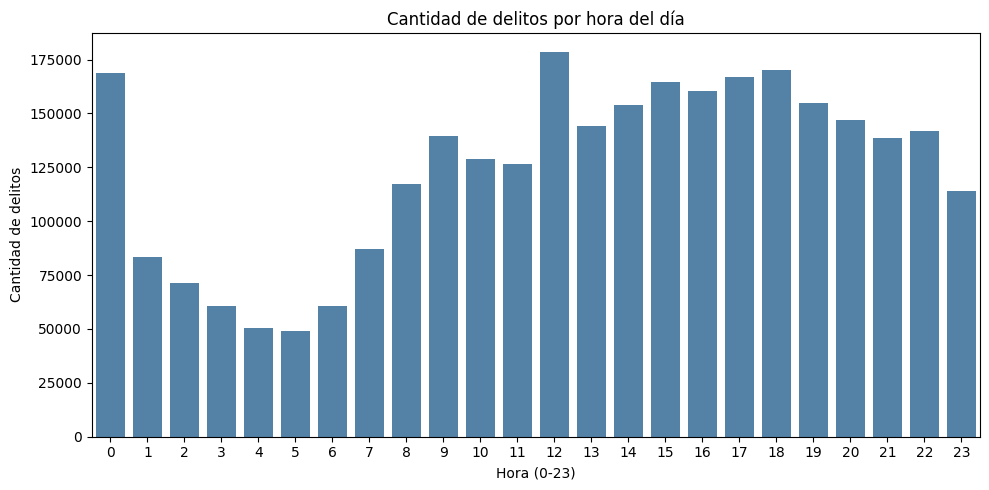

Horas pico de delitos: hour
12    178469
18    169971
0     168742
Name: count, dtype: int64


In [33]:

# Cuenta delitos por hora
delitos_por_hora = df_index['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=delitos_por_hora.index, y=delitos_por_hora.values, color='steelblue')
plt.title('Cantidad de delitos por hora del día')
plt.xlabel('Hora (0-23)')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

# Opcional: mostrar las 3 horas con más delitos
print("Horas pico de delitos:", delitos_por_hora.sort_values(ascending=False).head(3))

Detectar patrones nocturnos vs. diurnos

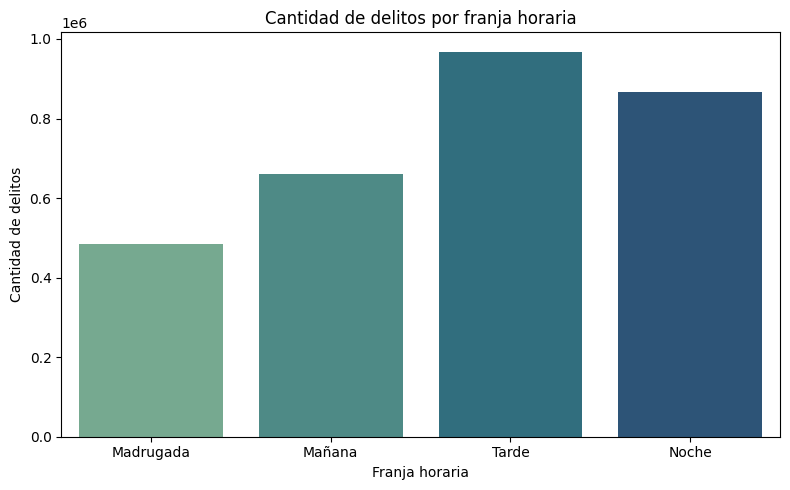

In [34]:
# Define franjas horarias
def categoria_franga_horaria(hora):
    if 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noche'
    else:
        return 'Madrugada'

df_index['franja_horaria'] = df_index['hour'].apply(categoria_franga_horaria)

# Cuenta delitos por franja horaria
delitos_por_franja = df_index['franja_horaria'].value_counts().reindex(['Madrugada','Mañana','Tarde','Noche'])

plt.figure(figsize=(8,5))
sns.barplot(x=delitos_por_franja.index, y=delitos_por_franja.values, palette='crest')
plt.title('Cantidad de delitos por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Cantidad de delitos')
plt.tight_layout()
plt.show()

In [35]:
df_index.head()

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only,arrest_mean,month,day_of_week,hour,franja_horaria
4,13204489,JG416325,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),0,0,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,41.871835,-87.626151,2023-09-06,11:00:00,2023-11-04,15:40:18,0.096448,9,Wednesday,11,Mañana
5,11695116,JC272771,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,0,0,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,41.856547,-87.695605,2019-05-21,08:20:00,2024-01-19,15:40:50,0.096448,5,Tuesday,8,Mañana
7,12729745,JF279458,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,1,0,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,41.945232,-87.766735,2022-06-14,14:47:00,2024-01-19,15:40:50,0.096448,6,Tuesday,14,Tarde
8,12835559,JF406130,004XX E 69TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,OTHER (SPECIFY),1,0,322,3.0,6.0,69.0,07,1180204.0,1859359.0,2022,41.769347,-87.615008,2022-09-21,22:00:00,2024-01-19,15:40:50,0.096448,9,Wednesday,22,Noche
9,13003649,JG177593,070XX S CLYDE AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE - PORCH / HALLWAY,1,0,331,3.0,5.0,43.0,05,1191427.0,1858753.0,2023,41.767419,-87.573890,2023-02-22,13:50:00,2024-01-19,15:40:50,0.096448,2,Wednesday,13,Tarde


## Modelo

In [36]:
vars_cluster = ['hour', 'day_of_week', 'primary_type', 'district', 'domestic']

df_cluster = df_index[vars_cluster].copy()
df_cluster.head()

,hour,day_of_week,primary_type,district,domestic
4,11,Wednesday,THEFT,1.0,0
5,8,Tuesday,BURGLARY,10.0,0
7,14,Tuesday,ROBBERY,16.0,0
8,22,Wednesday,MOTOR VEHICLE THEFT,3.0,0
9,13,Wednesday,BURGLARY,3.0,0


In [37]:
df_cluster = pd.get_dummies(df_cluster, drop_first=True)
df_cluster.head()

,hour,district,domestic,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,primary_type_BURGLARY,primary_type_CRIMINAL SEXUAL ASSAULT,primary_type_HOMICIDE,primary_type_MOTOR VEHICLE THEFT,primary_type_ROBBERY,primary_type_THEFT
4,11,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True
5,8,10.0,0,False,False,False,False,True,False,True,False,False,False,False,False
7,14,16.0,0,False,False,False,False,True,False,False,False,False,False,True,False
8,22,3.0,0,False,False,False,False,False,True,False,False,False,True,False,False
9,13,3.0,0,False,False,False,False,False,True,True,False,False,False,False,False


Escalar todas las variables numéricas

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

Elección del número de clusters

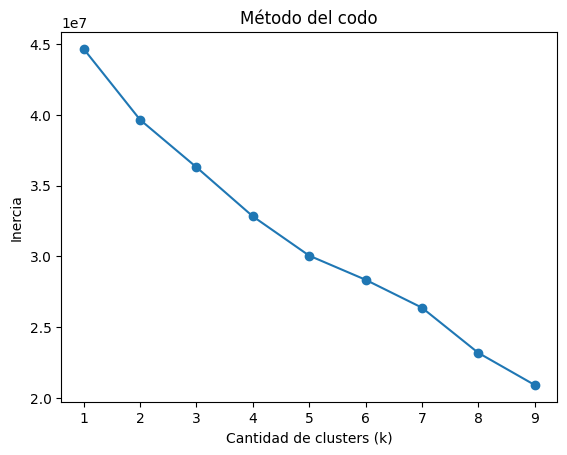

In [39]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, '-o')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.show()

## Primer cluster

In [47]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_index['cluster'] = kmeans.fit_predict(X_scaled)

In [48]:
# ¿Cuántos incidentes hay en cada cluster?
print(df_index['cluster'].value_counts())

# ¿Cómo se distribuyen por tipo de delito y franja horaria?
pd.crosstab(df_index['cluster'], df_index['primary_type'])

# Por franja horaria:
pd.crosstab(df_index['cluster'], df_index['franja_horaria'])

cluster
0    1734995
3     435369
2     419416
4     305202
1      82935
Name: count, dtype: int64


franja_horaria,Madrugada,Mañana,Noche,Tarde
cluster,,,,
0,241642,380612,476890,635851
1,16840,19591,22450,24054
2,80007,83425,156287,99697
3,72459,132485,102358,128067
4,72745,43931,107934,80592


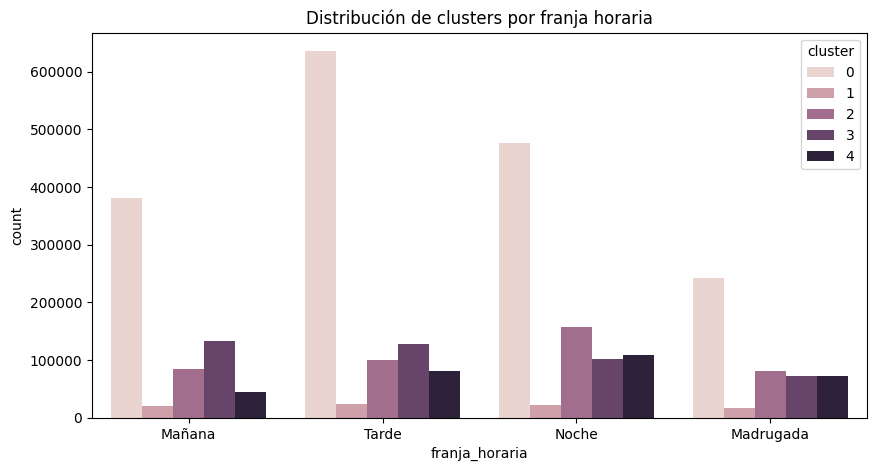

In [49]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_index, x='franja_horaria', hue='cluster')
plt.title('Distribución de clusters por franja horaria')
plt.show()

In [50]:
pd.crosstab(df_index['cluster'], df_index['primary_type'])

primary_type,ARSON,BURGLARY,CRIMINAL SEXUAL ASSAULT,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,THEFT
cluster,,,,,,,
0,13414,0,8194,12802,0,0,1700585
1,843,5468,2455,959,3650,6644,62916
2,0,0,0,0,419416,0,0
3,0,435369,0,0,0,0,0
4,0,0,0,0,0,305202,0


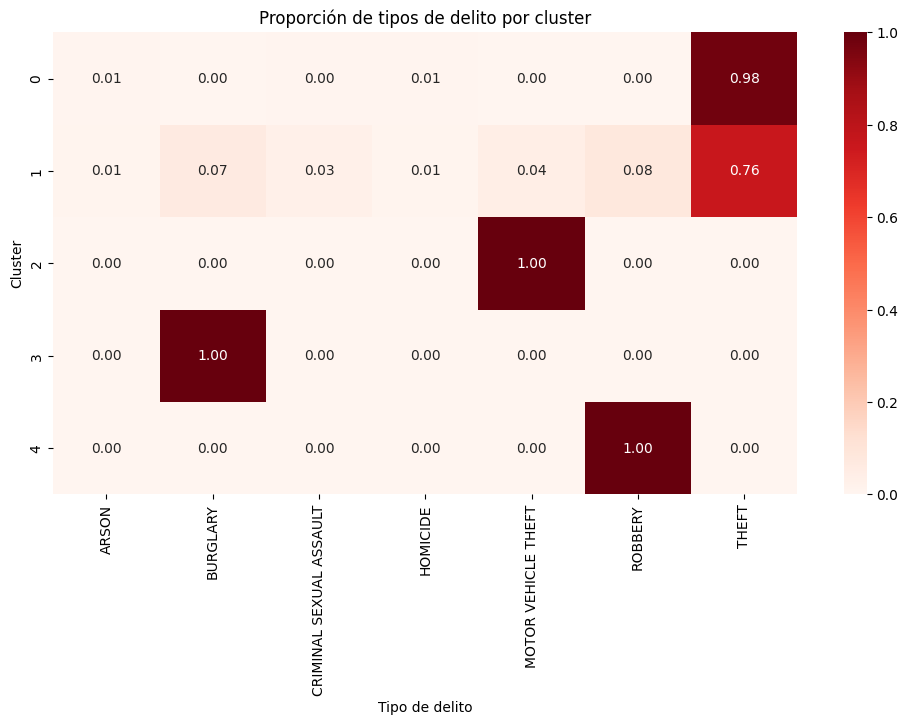

In [ ]:
tabla = pd.crosstab(df_index['cluster'], df_index['primary_type'], normalize='index')
plt.figure(figsize=(12,6))
sns.heatmap(tabla, annot=True, fmt=".2f", cmap='Reds')
plt.title('Proporción de tipos de delito por cluster')
plt.ylabel('Cluster')
plt.xlabel('Tipo de delito')
plt.show()

## Interpretación del análisis de clusters según tipo de delito
El análisis de clusters mediante el algoritmo K-Means permitió agrupar los incidentes delictivos en cinco grupos (clusters) diferenciados principalmente por el tipo de delito asociado a cada uno. A continuación, se describen las características principales de cada cluster, según el gráfico de calor generado:

 Cluster 0:
Este grupo está compuesto casi en su totalidad por incidentes de robo (“THEFT”), representando el 98% de todos los casos en este cluster. Esto indica que los delitos clasificados como robo conforman un grupo muy grande y homogéneo dentro del conjunto de datos analizados.

 Cluster 1:
Este cluster presenta una mayor diversidad de delitos. Aunque el 76% de los incidentes corresponden a “THEFT”, también se observan proporciones menores de otros delitos como “BURGLARY” (7%), “CRIMINAL SEXUAL ASSAULT” (3%), “ROBBERY” (8%) y “MOTOR VEHICLE THEFT” (4%). Esto sugiere que este grupo agrupa incidentes menos frecuentes o con características mixtas.

 Cluster 2:
En este grupo, el 100% de los incidentes corresponden a “MOTOR VEHICLE THEFT”, es decir, robos de vehículos. Esto evidencia que el algoritmo identificó un patrón claramente diferenciado para este tipo de delito.

 Cluster 3:
El 100% de los casos en este cluster corresponden a “BURGLARY”, es decir, robos a viviendas o establecimientos. Este grupo es altamente homogéneo y específico respecto al tipo de delito.

 Cluster 4:
De manera similar, este cluster está compuesto exclusivamente (100%) por incidentes de “ROBBERY”, es decir, robos en la vía pública (asaltos). Esto muestra que este tipo de delito también forma un grupo diferenciado y homogéneo.

#Conclusión:
El clustering realizado segmenta los incidentes principalmente según el tipo de delito, generando grupos altamente homogéneos para los delitos de “THEFT”, “BURGLARY”, “MOTOR VEHICLE THEFT” y “ROBBERY”. Solo uno de los clusters (Cluster 1) muestra una composición más variada, agrupando delitos menos frecuentes o con características mixtas. 

 ## Agrupación por modus operandi

In [56]:
# Asegúrate de que las columnas 'hour' y 'day_of_week' existan en df
if 'hour' not in df.columns:
	df['hour'] = pd.to_datetime(df['time_only'], errors='coerce').dt.hour
if 'day_of_week' not in df.columns:
	df['day_of_week'] = pd.to_datetime(df['date_only'], errors='coerce').dt.day_name()

vars_mo = ['primary_type', 'location_description', 'hour', 'day_of_week', 'domestic']

# Sample indices BEFORE creating dummies to avoid large memory usage
n_samples = min(100000, df.shape[0])
rng = np.random.default_rng()
sample_idx = rng.choice(df.dropna(subset=vars_mo).index, size=n_samples, replace=False)

# Work only with the sampled rows
df_sample = df.loc[sample_idx, vars_mo].dropna()
df_mo_sample = pd.get_dummies(df_sample, drop_first=True, sparse=True)

scaler = StandardScaler(with_mean=False)
X_mo_sample = scaler.fit_transform(df_mo_sample)

# X_mo_sample is already a dense array after StandardScaler
X_sample = X_mo_sample

kmeans_mo = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans_mo.fit_predict(X_sample)

# Assign cluster labels back to the sampled rows
df.loc[df_sample.index, 'mo_cluster'] = labels

# Análisis rápido
print(df['mo_cluster'].value_counts())

mo_cluster
2.0    80303
3.0    71532
0.0    27707
1.0    18610
4.0      570
Name: count, dtype: int64


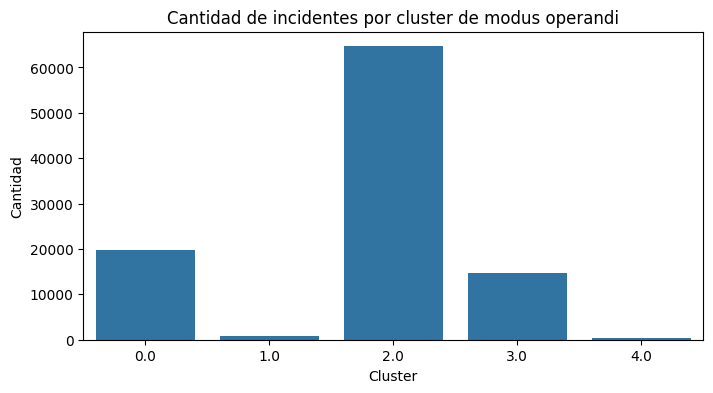

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df.loc[df['mo_cluster'].notnull()], x='mo_cluster', order=sorted(df['mo_cluster'].dropna().unique()))
plt.title('Cantidad de incidentes por cluster de modus operandi')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
# los delitos más comunes en cada cluster
df.groupby('mo_cluster')['primary_type'].value_counts(normalize=True).groupby(level=0).head(3)

mo_cluster  primary_type       
0.0         BATTERY                0.396470
            MOTOR VEHICLE THEFT    0.183672
            OTHER OFFENSE          0.164255
1.0         BATTERY                0.573401
            OTHER OFFENSE          0.151585
            ASSAULT                0.105320
2.0         THEFT                  0.252095
            CRIMINAL DAMAGE        0.133245
            NARCOTICS              0.111789
3.0         THEFT                  0.269935
            CRIMINAL DAMAGE        0.138078
            NARCOTICS              0.122924
4.0         CRIMINAL TRESPASS      0.242105
            THEFT                  0.229825
            NARCOTICS              0.140351
Name: proportion, dtype: float64

## Interpretación
Cluster 2 es el más numeroso, con más de 64,000 incidentes, destacándose claramente sobre los demás.

Clusters 0 y 3 también tienen una cantidad considerable de incidentes, aunque bastante menos que el cluster 2.

Clusters 1 y 4 agrupan una cantidad muy pequeña de incidentes en comparación con el resto.

Esto sugiere que la mayoría de los incidentes en el conjunto de datos comparten características de modus operandi que los agrupan en el cluster 2, mientras que otros patrones menos frecuentes quedan en clusters más pequeños.

#Conclusión

Clusters 0 y 1: Se relacionan principalmente con violencia interpersonal (agresiones, asaltos).

Clusters 2 y 3: Robos, daños a la propiedad y narcóticos, vinculados a delitos contra la propiedad.

Cluster 4: Allanamiento y delitos contra la propiedad, con presencia relevante de drogas.

## Agrupación por contexto socio-espacial
Incluye área comunitaria, tipo de delito, hora y si fue doméstico.


In [45]:
vars_socio = ['community_area', 'primary_type', 'hour', 'domestic']
df_socio = pd.get_dummies(df[vars_socio].dropna(), drop_first=True)

scaler = StandardScaler()
X_socio = scaler.fit_transform(df_socio)

kmeans_socio = KMeans(n_clusters=5, random_state=42, n_init=10)
df['socio_cluster'] = kmeans_socio.fit_predict(X_socio)

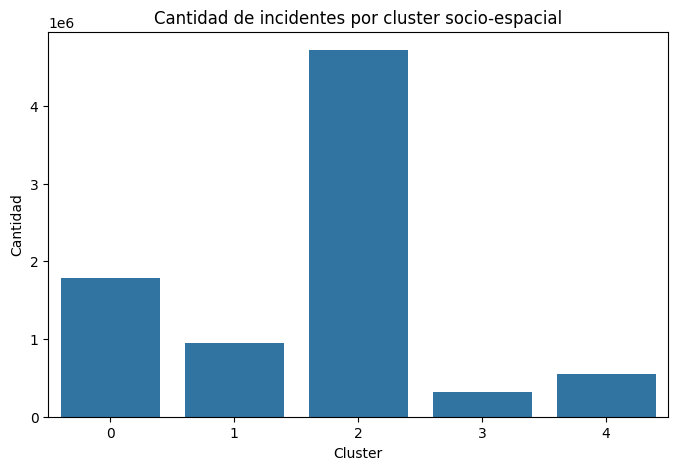

Estadísticas básicas por cluster socio-espacial:
               community_area       hour  domestic
socio_cluster                                     
0                   38.483037  12.772223  0.593199
1                   37.587725  12.748125  0.114894
2                   35.130639  13.214995  0.020300
3                   37.659425  12.916090  0.021305
4                   38.998310  13.611036  0.292976

Top tipos de delito por cluster:

Cluster 0:
primary_type
BATTERY                       0.847801
OTHER OFFENSE                 0.107527
OFFENSE INVOLVING CHILDREN    0.033394
Name: proportion, dtype: float64

Cluster 1:
primary_type
CRIMINAL DAMAGE    1.0
Name: proportion, dtype: float64

Cluster 2:
primary_type
THEFT        0.373834
NARCOTICS    0.161272
BURGLARY     0.093450
Name: proportion, dtype: float64

Cluster 3:
primary_type
ROBBERY    1.0
Name: proportion, dtype: float64

Cluster 4:
primary_type
ASSAULT    1.0
Name: proportion, dtype: float64


In [ ]:
# Visualización básica: cantidad de incidentes por cluster
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='socio_cluster', order=sorted(df['socio_cluster'].dropna().unique()))
plt.title('Cantidad de incidentes por cluster socio-espacial')
plt.xlabel('Cluster')
plt.ylabel('Cantidad')
plt.show()

# Interpretación básica: características promedio por cluster
print("Estadísticas básicas por cluster socio-espacial:")
print(df.groupby('socio_cluster')[['community_area', 'hour', 'domestic']].mean())

print("\nTop tipos de delito por cluster:")
for cluster, grupo in df.groupby('socio_cluster'):
    print(f"\nCluster {int(cluster)}:")
    print(grupo['primary_type'].value_counts(normalize=True).head(3))

# (Opcional) Si community_area tiene pocos valores únicos, también puedes ver su frecuencia:
n_areas = df['community_area'].nunique()
if n_areas < 20:
    print("\nTop áreas comunitarias por cluster:")
    for cluster, grupo in df.groupby('socio_cluster'):
        print(f"\nCluster {int(cluster)}:")
        print(grupo['community_area'].value_counts(normalize=True).head(3))

## Interpretación general
Cluster 0: Incidentes domésticos y agresiones, en zonas medias-altas y horario medio.

Cluster 1: Daños a la propiedad, rara vez domésticos, en áreas medias.

Cluster 2: Robos, drogas y allanamientos, en zonas de menor área y casi nunca domésticos.

Cluster 3: Robos violentos (robo a mano armada, asaltos), áreas medias.

Cluster 4: Asaltos, áreas más altas, con cierta proporción de casos domésticos y horario más tardío.